## 1. OBTAINING A CLEAN SAMPLE

Our aim is to obtain a clean sample of Star Forming Galaxies (SFGs). Within the final sample we can find sources with *stellarity >= 0.9* that could either be stars or quasars. Those sources might be useful for some science cases so they were left in the final dataset. We provide the necessary information so the final user can make an inform decision. 

Here we present some tools to separate galaxies from stars and quasars. In order to achieve this, we are going to make use of different color-color diagrams, some machine learning algorithms and the chi2 values from the SED fitting (CIGALE). 

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000) [with local modifications]
This notebook was executed on: 
2021-06-04 14:57:07.303436


In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time
import gc
import glob
from matplotlib_venn import venn2
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, QTable, Table, join, vstack, hstack, setdiff, unique
import numpy as np
import pymoc 
from pymoc import MOC


from herschelhelp_internal.masterlist import merge_catalogues, nb_merge_dist_plot, specz_merge
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
plt.rcParams['figure.figsize'] = [7, 7]

## 1. DATA EXPLORATION

#### LOAD IN CATALOGUE

In [4]:
DMU_DIR = '../dmu_products/'
FIELD = 'Herschel-Stripe-82'

In [5]:
fcat = Table.read('./data/Alist_ind_cat_sf_20210519.fits', memmap=True)
len(fcat)

107632

In [6]:
fcat[:5]

help_id,optband,nirband,ndet_total,field,ra,dec,hp_idx,ebv,redshift,zspec,f_spire_250,ferr_spire_250,flag_spire_250,f_spire_350,ferr_spire_350,flag_spire_350,f_spire_500,ferr_spire_500,flag_spire_500,cigale_mstar,cigale_mstar_err,cigale_sfr,cigale_sfr_err,cigale_dustlumin,cigale_dustlumin_err,cigale_dustlumin_ironly,cigale_dustlumin_ironly_err,cigale_chi2_opt,cigale_chi2_ir,cigale_chi2_red,cigale_chi2_ironly,stellarity,stellarity_origin,flag_cleaned,flag_merged,flag_gaia,flag_optnir_obs,flag_optnir_det,zspec_qual,zspec_association_flag,f_best_u,ferr_best_u,m_best_u,merr_best_u,flag_best_u,f_best_g,ferr_best_g,m_best_g,merr_best_g,flag_best_g,f_best_r,ferr_best_r,m_best_r,merr_best_r,flag_best_r,f_best_i,ferr_best_i,m_best_i,merr_best_i,flag_best_i,f_best_z,ferr_best_z,m_best_z,merr_best_z,flag_best_z,f_best_y,ferr_best_y,m_best_y,merr_best_y,flag_best_y,f_best_j,ferr_best_j,m_best_j,merr_best_j,flag_best_j,f_best_h,ferr_best_h,m_best_h,merr_best_h,flag_best_h,f_best_k,ferr_best_k,m_best_k,merr_best_k,flag_best_k,f_best_ks,ferr_best_ks,m_best_ks,merr_best_ks,flag_best_ks,f_irac_i1,ferr_irac_i1,m_irac_i1,merr_irac_i1,f_irac_i2,ferr_irac_i2,m_irac_i2,merr_irac_i2,f_irac_i3,ferr_irac_i3,m_irac_i3,merr_irac_i3,f_irac_i4,ferr_irac_i4,m_irac_i4,merr_irac_i4,f_mips_24,ferr_mips_24,flag_mips_24,f_pacs_green,ferr_pacs_green,flag_pacs_green,f_pacs_red,ferr_pacs_red,flag_pacs_red,flag_irac_i1,flag_irac_i2,flag_irac_i3,flag_irac_i4
,,,,,deg,deg,,,,,uJy,uJy,,uJy,uJy,,uJy,uJy,,solMass,solMass,solMass / yr,solMass / yr,W,W,W,W,,,,,,,,,,,,,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,mag,mag,uJy,uJy,,uJy,uJy,,uJy,uJy,,,,,
bytes27,float64,float64,float64,bytes18,float64,float64,int64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes20,bool,bool,int64,int64,int64,int64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,bool,float64,float64,bool,bool,bool,bool,bool
HELP_J000000.145-061343.694,1.0,2.0,3.0,Herschel-Stripe-82,0.0006036116266410582,-6.228803786144263,284376115,0.032967914750907115,0.1119,nan,31604.712890625,9258.4296875,False,2667.05322265625,3751.658203125,True,14230.20703125,6947.736328125,False,14259378035.985466,2017743737.6092722,1.9243343870885885,1.1201848167779158,7.402831193203582e+36,2.4977472170562455e+36,1.5400593825860042e+37,6.37183214459043e+36,6.420949825446042,1.7813022099038303,9.672795385154696,1.5774636325831106,0.9999809265136719,vista_stellarity,False,False,3,3,3,-99,False,nan,nan,nan,nan,False,24.29651451432248,0.18533516229205502,20.436140060424805,0.008282056078314781,False,79.32157463188337,0.32120406785258676,19.151521682739258,0.004396570380777121,False,148.25573598441594,0.4662600710721477,18.472471237182617,0.003414609469473362,False,197.2546787736457,0.8271784662465751,18.162431716918945,0.004552985075861216,False,213.26939052321842,2.199543222093782,18.077678680419922,0.011197686195373535,False,268.6312561035156,9.91836166381836,17.82710838317871,0.04008738324046135,False,280.71710205078125,15.30670166015625,17.779327392578125,0.05920209363102913,False,nan,nan,nan,nan,False,221.1717529296875,16.056001663208008,18.038175582885742,0.07881920039653778,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

### 1.2 COLOR-COLOR DIAGRAMS

In this section there are some represent color-color diagrams from literature.

- (g - z)  Vs  (r - [3.6]) -- *DESI Collaboration 2016*.

- (NUVrJ) Passive Vs Active galaxies --*Davidzon+2013*.



In [7]:
# bands
############
u = 'm_best_u'
g = 'm_best_g'
r = 'm_best_r'
z = 'm_best_z'
J = 'm_best_j'
i1 = 'm_irac_i1'


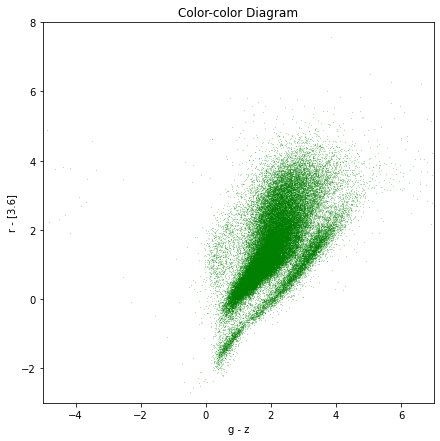

In [8]:
plt.scatter((fcat[g] - fcat[z]), (fcat[r] - fcat[i1]), s=0.01, c='green');
plt.title('Color-color Diagram')
plt.xlabel('g - z')
plt.ylabel('r - [3.6]');
plt.xlim(-5, 7);
plt.ylim(-3, 8);

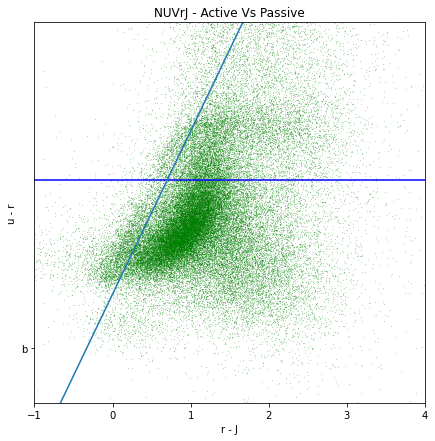

In [9]:
x = fcat[r] - fcat[J]
y = fcat[u] - fcat[r]

# Divide the plane between active and passive regions. The left-top corner is the locus of passive galaxies.
x1 = np.linspace(-1,4,100)
y1 = 3*x1 + 1

plt.scatter(x,y, s=0.01, c='green')
plt.plot(x1, y1, '-', 'b')
plt.hlines(3.1,-1,4, 'b')

plt.xlabel('r - J')
plt.ylabel('u - r')
plt.xlim(-1, 4)
plt.ylim(-1, 6)
plt.title('NUVrJ - Active Vs Passive')
plt.show()

In [10]:
ind_s = fcat['stellarity'] >= 0.9
ind_gal = fcat['stellarity'] < 0.9

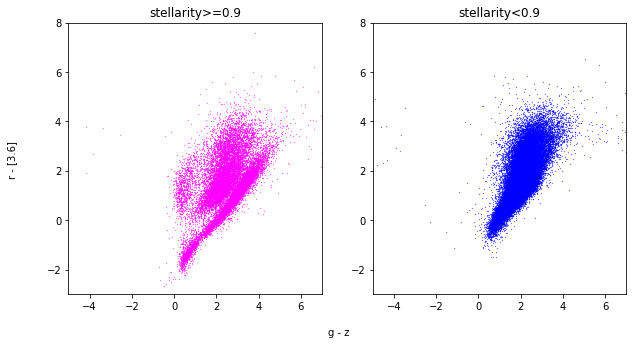

In [11]:
ind = [ind_s, ind_gal]
color = ['magenta', 'blue']
lab = ['stellarity>=0.9', 'stellarity<0.9']

fig, ax = plt.subplots(1,2, figsize=(10,5))
for i in range(len(ind)):
    ax[i].scatter((fcat[ind[i]][g] - fcat[ind[i]][z]), (fcat[ind[i]][r] - fcat[ind[i]][i1]), s=0.05, c=color[i], label=lab[i]);
    ax[i].set_xlim(-5, 7)
    ax[i].set_ylim(-3, 8)
    ax[i].set_title(lab[i])
    
fig.text(0.5, 0.01, 'g - z', ha='center')
fig.text(0.04, 0.5, 'r - [3.6]', va='center', rotation='vertical');
# fig.legend();

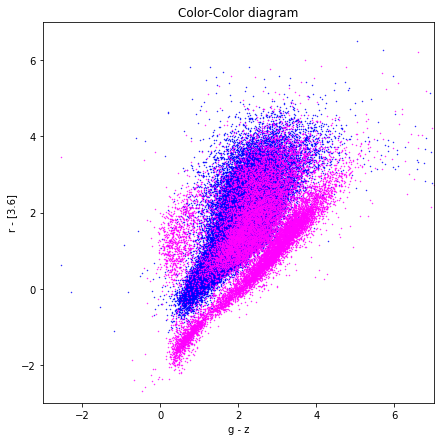

In [12]:
x = fcat[g] - fcat[z]
y = fcat[r] - fcat[i1]
# plt.scatter(x,y, s=0.01)
plt.scatter(x[ind_gal],y[ind_gal], s=0.2, label='stellarity<0.9', color='blue')
plt.scatter(x[ind_s],y[ind_s], s=0.2, label='stellarity>=0.9', color='magenta')
plt.xlabel('g - z')
plt.ylabel('r - [3.6]')
plt.xlim(-3, 7)
plt.ylim(-3, 7)
plt.title('Color-Color diagram')
# plt.legend()
plt.show()

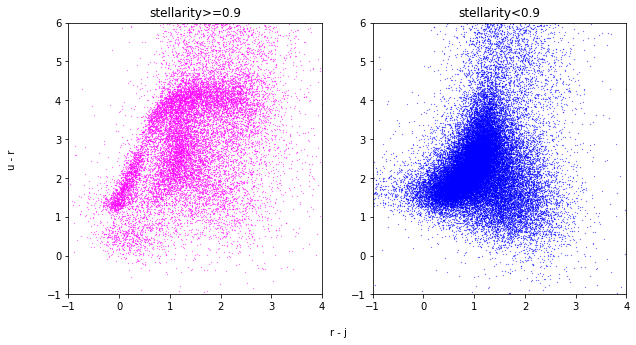

In [13]:
ind_stellarity = [ind_s, ind_gal]
color = ['magenta', 'blue']
lab = ['stellarity>=0.9', 'stellarity<0.9']

fig, ax = plt.subplots(1,2, figsize=(10,5))
for i in range(len(ind_stellarity)):
    ax[i].scatter((fcat[ind_stellarity[i]][r] - fcat[ind_stellarity[i]][J]), (fcat[ind_stellarity[i]][u] - fcat[ind_stellarity[i]][r]), s=0.05, c=color[i], label=lab[i]);
    ax[i].set_xlim(-1, 4)
    ax[i].set_ylim(-1, 6)
    ax[i].set_title(lab[i])
    
fig.text(0.5, 0.01, 'r - j', ha='center')
fig.text(0.04, 0.5, 'u - r', va='center', rotation='vertical');
# fig.legend();

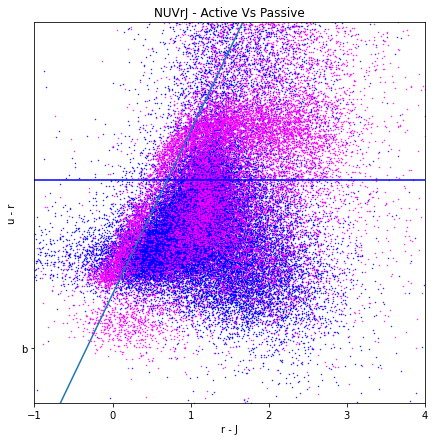

In [14]:
x = fcat[r] - fcat[J]
y = fcat[u] - fcat[r]
# plt.scatter(x,y, s=0.01)
plt.scatter(x[ind_gal],y[ind_gal], s=0.2, label='stellarity<0.9', color='blue')
plt.scatter(x[ind_s],y[ind_s], s=0.2, label='stellarity>=0.9', color='magenta')
x1 = np.linspace(-1,4,100)
y1 = 3*x1 + 1
plt.plot(x1, y1, '-', 'b')
plt.hlines(3.1,-1,4, 'b')
plt.xlabel('r - J')
plt.ylabel('u - r')
plt.xlim(-1, 4)
plt.ylim(-1, 6)
plt.title('NUVrJ - Active Vs Passive')
# plt.legend()
plt.show()

### 1.3 Chi2 distributions from SED fitting

In this section we'll see different chi2 fitting outputs from the SED fitting.

- *chi2_opt*
- *chi2_ir*
- *chi2_red*
- *chi2_ironly*



In [15]:
chi2_cols = ['cigale_chi2_opt','cigale_chi2_red']#, 'cigale_chi2_ir', 'cigale_chi2_ironly']

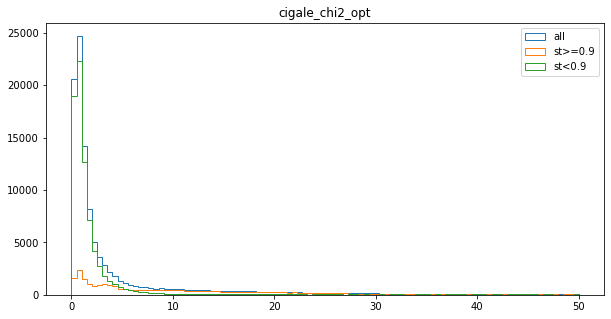

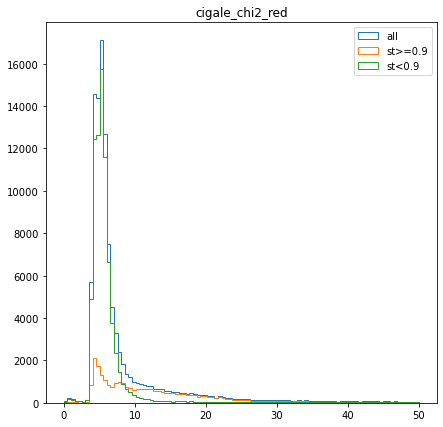

In [16]:
plt.figure(figsize=(10,5))
for chi2 in chi2_cols:
    plt.hist(fcat[chi2], bins=np.linspace(0,50,100), histtype='step', label='all')
    plt.hist(fcat[ind_s][chi2], bins=np.linspace(0,50,100), histtype='step',label='st>=0.9')
    plt.hist(fcat[ind_gal][chi2], bins=np.linspace(0,50,100), histtype='step', label='st<0.9')
    plt.title(str(chi2))
    plt.legend()
    plt.show()

### Based on the above histograms, we stablish a cut on the Chi2 value

In [17]:
ind_s_chi2 = (fcat['cigale_chi2_opt'] > 5) | (fcat['cigale_chi2_red'] > 10)

# Different selection based on stellarity and Chi2
ind_s2 = ind_s & ind_s_chi2    # Stellarity >= 0.9 & chi2 > threshold
ind_s3 = ind_s & ~ind_s_chi2   # Stellarity >= 0.9 & chi2 < threshold
ind_g2 = ind_gal & ~ind_s_chi2 # Stellarity  < 0.9 & chi2 < threshold
ind_g3 = ind_gal & ind_s_chi2  # Stellarity  < 0.9 & chi2 > threshold

print('There are {} sources with stellarity >= 0.9.'.format(ind_s.sum()))
print('{} of them are above the chi2 threshold. We will descard this sources as possible stars.'.format(ind_s2.sum()))
print('The rest {} sources have a good chi2 value.'.format(ind_s3.sum()))


There are 28531 sources with stellarity >= 0.9.
16909 of them are above the chi2 threshold. We will descard this sources as possible stars.
The rest 11622 sources have a good chi2 value.


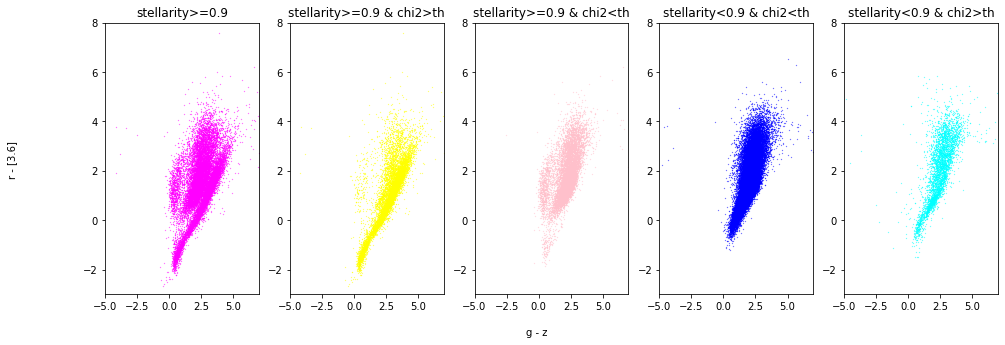

In [18]:
ind_stellarity = [ind_s, ind_s2, ind_s3, ind_g2, ind_g3]
color = ['magenta', 'yellow', 'pink', 'blue','cyan']
lab = ['stellarity>=0.9', 'stellarity>=0.9 & chi2>th', 'stellarity>=0.9 & chi2<th', 'stellarity<0.9 & chi2<th', 'stellarity<0.9 & chi2>th']

fig, ax = plt.subplots(1,len(ind_stellarity), figsize=(16,5))
for i in range(len(ind_stellarity)):
    ax[i].scatter(fcat[ind_stellarity[i]][g] - fcat[ind_stellarity[i]][z], fcat[ind_stellarity[i]][r] - fcat[ind_stellarity[i]][i1], s=0.05, c=color[i], label=lab[i]);
    ax[i].set_xlim(-5, 7)
    ax[i].set_ylim(-3, 8)
    ax[i].set_title(lab[i])
    
fig.text(0.5, 0.01, 'g - z', ha='center')
fig.text(0.04, 0.5, 'r - [3.6]', va='center', rotation='vertical');
# fig.legend();

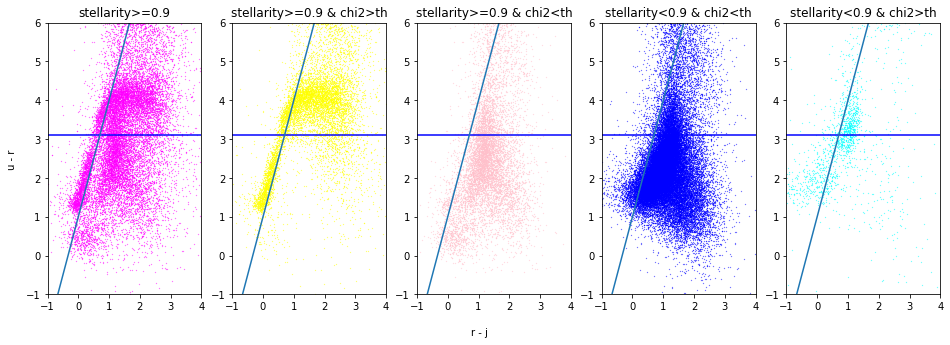

In [19]:
x1 = np.linspace(-1,4,100)
y1 = 3*x1 + 1

ind_stellarity = [ind_s, ind_s2, ind_s3, ind_g2, ind_g3]
color = ['magenta', 'yellow', 'pink', 'blue', 'cyan']
lab = ['stellarity>=0.9', 'stellarity>=0.9 & chi2>th', 'stellarity>=0.9 & chi2<th', 'stellarity<0.9 & chi2<th', 'stellarity<0.9 & chi2>th']

fig, ax = plt.subplots(1,len(ind_stellarity), figsize=(16,5))
for i in range(len(ind_stellarity)):
    ax[i].scatter((fcat[ind_stellarity[i]][r] - fcat[ind_stellarity[i]][J]), (fcat[ind_stellarity[i]][u] - fcat[ind_stellarity[i]][r]), s=0.05, c=color[i]);
    ax[i].plot(x1, y1)
    ax[i].hlines(3.1,-1,4, 'b')
    ax[i].set_xlim(-1, 4)
    ax[i].set_ylim(-1, 6)
    ax[i].set_title(lab[i])
    
fig.text(0.5, 0.01, 'r - j', ha='center')
fig.text(0.09, 0.5, 'u - r', va='center', rotation='vertical');
# fig.legend();

In [20]:
ind_g3.sum()

6326

In [21]:
ind_final = ind_s3 | ind_gal
ind_final.sum()

90723

In [22]:
final_sample = fcat[ind_final]
# final_sample.write('./data/clean_sfg_sample_20210524.fits')